In [2]:
%matplotlib inline
import numpy as np
import sys, scipy
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
import librosa

sys.path.append('../src')
import laplacian
import RecurrenceMatrix as RM

# Create pseudo-signal
- Since default frequency is 22050, and therefore the cycle for each is 22050 data points

(441000,)


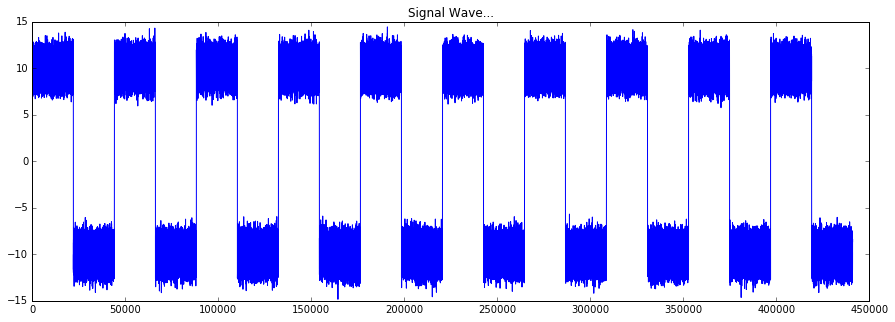

In [3]:
mu, sigma, length = 10, 1, 22050 # mean and standard deviation

signal = []
for i in xrange(20):
    if i%2==0:
        signal += list(np.random.normal(mu, sigma, length))
    else:
        signal += list(np.random.normal(-mu, sigma, length))
signal = np.array(signal)

print signal.shape
plt.figure(figsize=(15, 5))
plt.title('Signal Wave...')
plt.plot(signal)
plt.ylim((-15,15))
plt.show()

# Convert time signal to feature vector

In [5]:
cqt = np.transpose(librosa.cqt(signal))
print signal.shape, cqt.shape

(441000,) (862, 84)


# Constructing gaussian matrix
-- based on method of w[i,j] = exp(- norm2(x_i-x_j)^2/sigma^2), where x_i, x_j is feature at each time point, sigma is the parameter to learn

In [23]:
gm = RM.feature2GaussianMatrix(cqt, 1.5)
print gm.shape
print "is symmetric: ", (gm==np.transpose(gm)).all()

(862, 862)
is symmetric:  True


# Laplacian --> Eigenvectors

(862, 10)


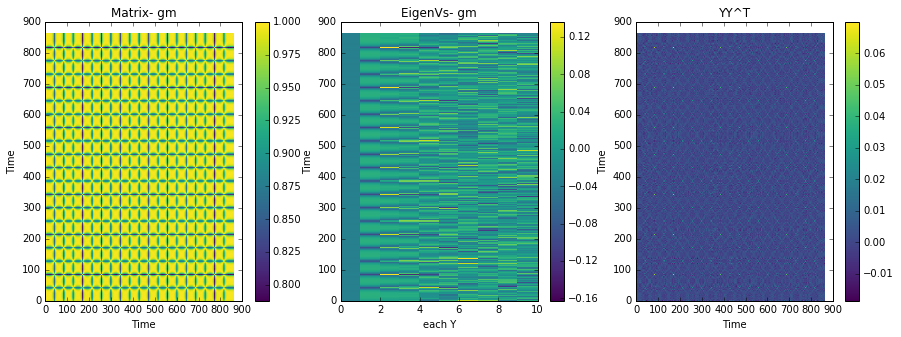

In [11]:
Y = laplacian.getNormLaplacian(gm, 10) #similarity matrix, top m eigenvectors
YY = np.dot(Y[:,:], np.transpose(Y)[:,:])
print Y.shape
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.pcolor(gm, cmap="viridis")
plt.colorbar()
plt.title('Matrix- gm')
plt.xlabel('Time')
plt.ylabel('Time')

plt.subplot(1, 3, 2)
plt.pcolor(Y, cmap="viridis")
plt.colorbar()
plt.title('EigenVs- gm')
plt.xlabel('each Y')
plt.ylabel('Time')

plt.subplot(1, 3, 3)
plt.pcolor(YY, cmap="viridis")
plt.colorbar()
plt.title('YY^T')
plt.ylabel('Time')
plt.xlabel('Time')
plt.show()

# Laplacina --> Eigenvectors --> Boundary Detection
-- As there are 20 cycles, and actually 40 signal transitions, boundary detection can get 40 bounday lines

[29, 57, 71, 99, 116, 142, 159, 186, 201, 229, 244, 272, 287, 315, 331, 358, 373, 402, 416, 445, 460, 488, 503, 530, 546, 575, 589, 616, 633, 658, 660, 661, 676, 702, 718, 746, 761, 789, 803, 832]


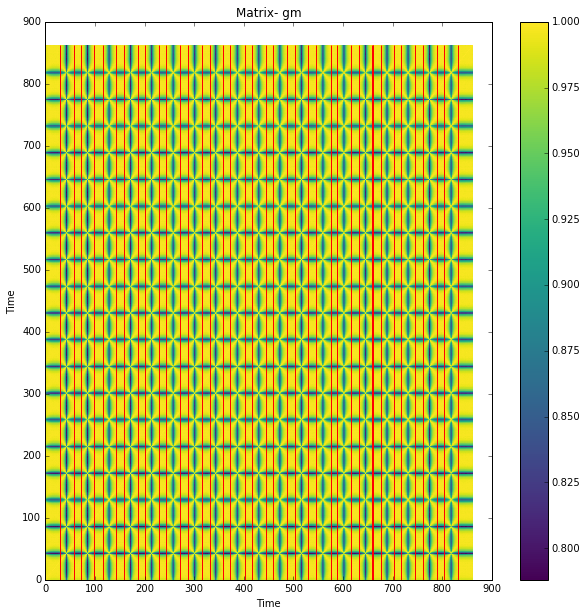

In [12]:
from sklearn.cluster import KMeans
nCluster = 2
Y3 = laplacian.getNormLaplacian(gm, 10) #similarity matrix, top m eigenvectors

def boundaryDetection(Y, nCluster):
    row_leng = np.linalg.norm(Y, axis=1) #get length of each row
    row_leng[row_leng==0] = 1 #replace the legth of 0 to 1
    Y_norm = Y / row_leng[:, np.newaxis]

    clf = KMeans(n_clusters=nCluster, max_iter=100).fit(Y_norm)
    centroids, labels = clf.cluster_centers_, clf.labels_

    boundary = []
    for idx in xrange(len(labels)-1):
        if labels[idx] != labels[idx+1]:
            boundary += [idx]
    
    return boundary, centroids

b, c = boundaryDetection(Y3, nCluster)
print b

plt.figure(figsize=(10, 10))
plt.pcolor(gm, cmap="viridis")
plt.colorbar()
plt.vlines(b, 0, 862, color='r')
plt.title('Matrix- gm')
plt.xlabel('Time')
plt.ylabel('Time')

# Frame to time
-- Convert boundary time frame to time

In [13]:
print b
print librosa.frames_to_time(b)

[29, 57, 71, 99, 116, 142, 159, 186, 201, 229, 244, 272, 287, 315, 331, 358, 373, 402, 416, 445, 460, 488, 503, 530, 546, 575, 589, 616, 633, 658, 660, 661, 676, 702, 718, 746, 761, 789, 803, 832]
[  0.67337868   1.32353741   1.64861678   2.29877551   2.69351474
   3.29723356   3.69197279   4.31891156   4.66721088   5.31736961
   5.66566893   6.31582766   6.66412698   7.31428571   7.68580499
   8.31274376   8.66104308   9.33442177   9.65950113  10.33287982
  10.68117914  11.33133787  11.67963719  12.30657596  12.67809524
  13.35147392  13.67655329  14.30349206  14.69823129  15.27873016
  15.32517007  15.34839002  15.69668934  16.30040816  16.67192744
  17.32208617  17.67038549  18.32054422  18.64562358  19.31900227]


# Construct Recurrent Matrix from jams interval

In [3]:

# nSample, nFeature = gm.shape
m = RM.label2RecurrenceMatrix("../data/2.jams", 100000)

In [ ]:
L_true = scipy.sparse.csgraph.laplacian(m, normed=True)

In [ ]:
print m.shape
import gradient
L_true = gradient.getLaplacianMatrix(m)

In [46]:

term = ['up', 'down']
term2 = ['transitDown', 'transitUp']
transitDelta = 50
allInterval = []

for i in xrange(20):
    allInterval += [[np.array([22050*i+transitDelta, 22050*(i+1)-transitDelta]).astype(float), term[i%2]]]
    allInterval += [[np.array([22050*(i+1)-transitDelta, 22050*(i+1)+transitDelta]).astype(float), term2[i%2]]]
allInterval.pop()
print allInterval

[[array([    50.,  22000.]), 'up'], [array([ 22000.,  22100.]), 'transitDown'], [array([ 22100.,  44050.]), 'down'], [array([ 44050.,  44150.]), 'transitUp'], [array([ 44150.,  66100.]), 'up'], [array([ 66100.,  66200.]), 'transitDown'], [array([ 66200.,  88150.]), 'down'], [array([ 88150.,  88250.]), 'transitUp'], [array([  88250.,  110200.]), 'up'], [array([ 110200.,  110300.]), 'transitDown'], [array([ 110300.,  132250.]), 'down'], [array([ 132250.,  132350.]), 'transitUp'], [array([ 132350.,  154300.]), 'up'], [array([ 154300.,  154400.]), 'transitDown'], [array([ 154400.,  176350.]), 'down'], [array([ 176350.,  176450.]), 'transitUp'], [array([ 176450.,  198400.]), 'up'], [array([ 198400.,  198500.]), 'transitDown'], [array([ 198500.,  220450.]), 'down'], [array([ 220450.,  220550.]), 'transitUp'], [array([ 220550.,  242500.]), 'up'], [array([ 242500.,  242600.]), 'transitDown'], [array([ 242600.,  264550.]), 'down'], [array([ 264550.,  264650.]), 'transitUp'], [array([ 264650.,  

In [47]:
# librosa.core.time_to_frames(x,sr=22050)
sr = 22050

def f2(x):
    return librosa.core.time_to_frames(x, sr=22050, hop_length=512, n_fft=None)

allInterval = [[np.apply_along_axis(f2, 0, elm[0]/22050), elm[1]] for elm in allInterval]
# allInterval = [elm[0] for elm in allInterval]
print allInterval

[[array([ 0, 42]), 'up'], [array([42, 43]), 'transitDown'], [array([43, 86]), 'down'], [array([86, 86]), 'transitUp'], [array([ 86, 129]), 'up'], [array([129, 129]), 'transitDown'], [array([129, 172]), 'down'], [array([172, 172]), 'transitUp'], [array([172, 215]), 'up'], [array([215, 215]), 'transitDown'], [array([215, 258]), 'down'], [array([258, 258]), 'transitUp'], [array([258, 301]), 'up'], [array([301, 301]), 'transitDown'], [array([301, 344]), 'down'], [array([344, 344]), 'transitUp'], [array([344, 387]), 'up'], [array([387, 387]), 'transitDown'], [array([387, 430]), 'down'], [array([430, 430]), 'transitUp'], [array([430, 473]), 'up'], [array([473, 473]), 'transitDown'], [array([473, 516]), 'down'], [array([516, 516]), 'transitUp'], [array([516, 559]), 'up'], [array([559, 559]), 'transitDown'], [array([559, 602]), 'down'], [array([602, 603]), 'transitUp'], [array([603, 645]), 'up'], [array([645, 646]), 'transitDown'], [array([646, 688]), 'down'], [array([688, 689]), 'transitUp'],